# Conv Architecture Improvement PyTorch

**import torch**

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchsummary import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd

Let's decribe setting for `PyTorch`.

In [2]:
def torch_stats():
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32

    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)

        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)

    num_workers=os.cpu_count()
    print ('available number of workers (CPU cores):',num_workers)

    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed_all(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn


In [3]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 2.6
Using device: cuda
cuda:  cu124
Cuda is available: True
number of devices: 1
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
default data type: torch.float32
available number of workers (CPU cores): 2


/usr/local/lib/python3.11/dist-packages/torch/__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


**Modefications of LeNet**

In this workshop we will start with `LeNet`-like backbone, and then will try to improve it.



The following example will show you some improvements of the architecture, which you need to know
* Replace maxpool on conv with stride 2.
```python
    conv1   = nn.Conv2d(in_channels = 3, out_channels = 6,
                        kernel_size = 5,  stride = 2,
                        padding     = 2, dilation = 1)
```
* Cascade Conv.
```python
    conv2_1   = nn.Conv2d(in_channels = 6, out_channels = 16,
                          kernel_size = 3, padding      = 1)

    conv2_2   = nn.Conv2d(in_channels = 16, out_channels = 16,
                          kernel_size  = 3, padding      = 1)

    conv2 = nn.Sequential(conv2_1, nn.ReLU(),
                          conv2_2, nn.BatchNorm2d(16))
```
* Spatially-separable conv.
```python
    conv3_1 = nn.Conv2d(in_channels  = 16,    out_channels = 32,
                        kernel_size  = (3,1), padding      = 1)

    conv3_2 = nn.Conv2d(in_channels  = 32,    out_channels = 32,
                        kernel_size  = (1,3), padding      = 1)

    conv3 = nn.Sequential(conv3_1, nn.ReLU(),
                          conv3_2)
```
* BottleNeck Residual layer (layer with pointwise conv and with residual connection)
```python
    conv1x1_1 = nn.Conv2d(in_channels = 32, out_channels = 16,
                          kernel_size = 1)

    conv3x3  = nn.Conv2d(in_channels = 16, out_channels = 16,
                         kernel_size = 3,  padding      = 1)

    conv1x1_2 = nn.Conv2d(in_channels = 16, out_channels = 32,
                          kernel_size = 1)

    main_block = nn.Sequential(conv1x1_1, nn.BatchNorm2d(16), nn.ReLU(),
                               conv3x3,   nn.BatchNorm2d(16), nn.ReLU(),
                               conv1x1_2, nn.BatchNorm2d(32))
        #-------
        h = self.main_block(x)
        x = x+h
        x = torch.relu(x)
```
* DepthWise Separable conv
```python
    depth_conv = nn.Conv2d(in_channels = 32, out_channels = 32,  
                           kernel_size = 3,  groups       = 32,
                           padding     = 1)

    point_conv = nn.Conv2d(in_channels = 32, out_channels = 64,
                           kernel_size = 1)

    conv5 = nn.Sequential(depth_conv,  nn.BatchNorm2d(32), nn.ReLU(),
                               point_conv)
```
* BatchNorm
```python
   bn1 = nn.BatchNorm2d(6)
```
* MaxPool
```python
   maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
```
* Global Average pool
```python
    self.gap = nn.AdaptiveAvgPool2d((1,1))
```

In [4]:
class LeNet(nn.Module):

    def __init__(self, in_channels, n_classes):
        super().__init__()

        self.in_channels = in_channels
        self.n_classes   = n_classes

        # Convolution with stride 2
        self.conv1   = nn.Conv2d(in_channels  = self.in_channels,
                                 out_channels = 6,
                                 kernel_size  = 5,
                                 stride       = 2,
                                 padding      = 2,
                                 dilation     = 1)


        # Cascade Convolution
        conv2_1   = nn.Conv2d(in_channels     = 6,
                                 out_channels = 16,
                                 kernel_size  = 3,
                                 padding      = 1)

        conv2_2   = nn.Conv2d(in_channels     = 16,
                                 out_channels = 16,
                                 kernel_size  = 3,
                                 padding      = 1)

        self.conv2 = nn.Sequential(conv2_1,
                                   nn.ReLU(),
                                   conv2_2,
                                   nn.BatchNorm2d(16))

        # Spatially-Separable Convolution
        conv3_1 = nn.Conv2d(in_channels  = 16,
                            out_channels = 32,
                            kernel_size  = (3,1),
                            padding      = 1)

        conv3_2 = nn.Conv2d(in_channels  = 32,
                            out_channels = 32,
                            kernel_size  = (1,3),
                            padding      = 1)

        self.conv3 = nn.Sequential(conv3_1,
                                   nn.ReLU(),
                                   conv3_2)

        # Residual bottleneck layer
        conv1x1_1 = nn.Conv2d(in_channels  = 32,
                              out_channels = 16,
                              kernel_size  = 1)

        conv3x3  = nn.Conv2d(in_channels  = 16,
                             out_channels = 16,
                             kernel_size  = 3,
                             padding      = 1)

        conv1x1_2 = nn.Conv2d(in_channels  = 16,
                              out_channels = 32,
                              kernel_size  = 1)

        self.main_block = nn.Sequential(conv1x1_1,
                                        nn.BatchNorm2d(16),
                                        nn.ReLU(),
                                        conv3x3,
                                        nn.BatchNorm2d(16),
                                        nn.ReLU(),
                                        conv1x1_2,
                                        nn.BatchNorm2d(32))

        # Depthwise Separable Convolution
        depth_conv = nn.Conv2d(in_channels  = 32,
                               out_channels = 32,
                               kernel_size  = 3,
                               groups       = 32,
                               padding      = 1)

        point_conv = nn.Conv2d(in_channels  = 32,
                               out_channels = 64,
                               kernel_size  = 1)

        self.conv5 = nn.Sequential(depth_conv,
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(),
                                   point_conv)


        #normalization
        self.bn1 = nn.BatchNorm2d(6)

        # pooling
        self.maxpool = nn.MaxPool2d(kernel_size = 2,
                                    stride      = 2)

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1,1))

        # classification
        self.fc_out = nn.Linear(in_features = 64,
                                out_features = self.n_classes)


    def forward(self, x):

        # 1-st layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)

        #2-nd layer
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.maxpool(x)

        #3-nd layer
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.maxpool(x)

        #4-th layer
        h = self.main_block(x)
        x = x+h
        x = torch.relu(x)

        #5-th layer
        x = self.conv5(x)
        x = torch.relu(x)

        # 1-st fc layer
        x = self.gap(x)
        h = torch.flatten(x, 1)
        x = self.fc_out(h)

        return x#torch.softmax(x, dim=1)

In [5]:
model = LeNet(3,10)

# from torchsummary import summary
summary(model, input_size = (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 16, 16]             456
       BatchNorm2d-2            [-1, 6, 16, 16]              12
            Conv2d-3           [-1, 16, 16, 16]             880
              ReLU-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 16, 16, 16]           2,320
       BatchNorm2d-6           [-1, 16, 16, 16]              32
         MaxPool2d-7             [-1, 16, 8, 8]               0
            Conv2d-8            [-1, 32, 8, 10]           1,568
              ReLU-9            [-1, 32, 8, 10]               0
           Conv2d-10           [-1, 32, 10, 10]           3,104
        MaxPool2d-11             [-1, 32, 5, 5]               0
           Conv2d-12             [-1, 16, 5, 5]             528
      BatchNorm2d-13             [-1, 16, 5, 5]              32
             ReLU-14             [-1, 1

let's also see on parameters

In [6]:
params = list(model.named_parameters())

# print(params)
for idx in range(len(params)):
    print(params[idx][0],'\t', params[idx][1].size())
print('\n',10*'--')
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.0.weight 	 torch.Size([16, 6, 3, 3])
conv2.0.bias 	 torch.Size([16])
conv2.2.weight 	 torch.Size([16, 16, 3, 3])
conv2.2.bias 	 torch.Size([16])
conv2.3.weight 	 torch.Size([16])
conv2.3.bias 	 torch.Size([16])
conv3.0.weight 	 torch.Size([32, 16, 3, 1])
conv3.0.bias 	 torch.Size([32])
conv3.2.weight 	 torch.Size([32, 32, 1, 3])
conv3.2.bias 	 torch.Size([32])
main_block.0.weight 	 torch.Size([16, 32, 1, 1])
main_block.0.bias 	 torch.Size([16])
main_block.1.weight 	 torch.Size([16])
main_block.1.bias 	 torch.Size([16])
main_block.3.weight 	 torch.Size([16, 16, 3, 3])
main_block.3.bias 	 torch.Size([16])
main_block.4.weight 	 torch.Size([16])
main_block.4.bias 	 torch.Size([16])
main_block.6.weight 	 torch.Size([32, 16, 1, 1])
main_block.6.bias 	 torch.Size([32])
main_block.7.weight 	 torch.Size([32])
main_block.7.bias 	 torch.Size([32])
conv5.0.weight 	 torch.Size([32, 1, 3, 3])
conv5.0.bias 	 torch.Size([32])
c

now we can test output of the network without training for random input

In [7]:
X = torch.randn(1, 3, 32, 32) # Batch Size x Channels x Wide x Height
out = model(X)
print(out.data.cpu().numpy(), '\n max position (Class index):', out.argmax().item())


[[-0.16007745  0.30156374 -0.11510815  0.04122951 -0.00649796 -0.2692149
   0.02351473  0.02438911  0.09155061  0.06225788]] 
 max position (Class index): 1


In this we will use `CIFAR 10` dataset as in previous one.

Let's remind some examples of `Cifar10`

![](https://debuggercafe.com/wp-content/uploads/2019/10/cifar10_plot.png)

Now we cam load dataset. For the first we can describes augmentation transforms.

In [8]:
MEAN = np.asarray([0.485, 0.456, 0.406])
STD  = np.asarray([0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
                            transforms.Resize(36),
                            transforms.RandomRotation(5),
                            transforms.RandomHorizontalFlip(0.5),
                            transforms.RandomCrop(32, padding=2),
                            transforms.ColorJitter(brightness=0.5,
                                                   contrast=0.5,
                                                   saturation=0.5,
                                                   hue=0.5),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=MEAN, std=STD)
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=MEAN, std=STD)
                                     ])

create dataset

In [9]:
trainset = torchvision.datasets.CIFAR10(root      = './data',
                                        train     = True,
                                        download  = True,
                                        transform = train_transforms)


testset = torchvision.datasets.CIFAR10(root      = './data',
                                       train     = False,
                                       download  = True,
                                       transform = test_transforms)


names_classes = trainset.classes
print(names_classes)


100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Define train and test data

In [10]:
VALID_RATIO = 0.9

n_train_examples = int(len(trainset) * VALID_RATIO)

n_valid_examples = len(trainset) - n_train_examples

if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
    kwarg = {'generator':torch.Generator(device='cpu')}

trainset, validset = data.random_split(trainset,
                                           [n_train_examples, n_valid_examples], **kwarg)

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

In [11]:
print(f'Number of training examples: {len(trainset)}')
print(f'Number of validation examples: {len(validset)}')
print(f'Number of testing examples: {len(testset)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


DataLoader

In [12]:
BATCH_SIZE = 128

if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
     kwarg = {'num_workers':0}

trainloader = data.DataLoader(trainset,shuffle=True,batch_size=BATCH_SIZE, **kwarg)

validloader = data.DataLoader(validset,batch_size=BATCH_SIZE, **kwarg)

testloader  = data.DataLoader(testset,batch_size=BATCH_SIZE, **kwarg)

And visualization

(546, 274, 3)


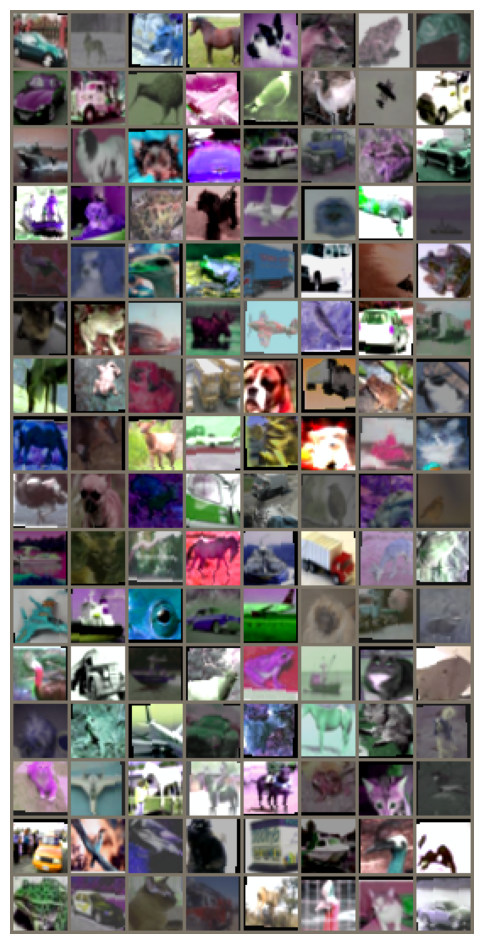

first raw classes automobile  deer  deer horse   dog horse  frog   cat automobile truck  bird airplane  bird  deer airplane truck
torch.Size([128, 3, 32, 32])


In [13]:
def imshow(images, mean=MEAN, std=STD):

    img = torchvision.utils.make_grid(images)


    img = img.data.cpu().numpy().transpose((1,2,0))
    print(img.shape)
    img = (img * std + mean) # unnormalize


    plt.figure(figsize=(16,12))
    plt.imshow(img); plt.axis('off'); plt.show()


images, labels = next(iter(trainloader))

imshow(images)

print('first raw classes',' '.join('%5s' % names_classes[labels[j]] for j in range(BATCH_SIZE//8)))

print(images.shape)

Weights Initialization

In [14]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)

model.apply(init_weights);


auxiliary routines

In [15]:
def train(model, dataloader, optimizer, criterion, metric,  device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x, y = x.to(device).float(), y.to(device).long()

        optimizer.zero_grad(set_to_none = True)

        y_pred = model(x) #model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metric(y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x, y = x.to(device).float(), y.to(device).long()

            y_pred = model.forward(x) #model(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
def fit(model, train_loader, val_loader, optimizer, criterion, metric, epochs = 10,
        device='cpu', scheduler = None,  path_best = 'best_model.pt', verbose = True):

    best_valid_loss = float('inf')
    history = {'train_loss':np.zeros(epochs),
               'valid_loss':np.zeros(epochs),
               'train_acc':np.zeros(epochs),
               'valid_acc':np.zeros(epochs)}

    for epoch in trange(epochs):

        start_time = time.monotonic()

        train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
        valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

        if scheduler != None:
            scheduler.step()

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), path_best)

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if verbose == True:
            if epoch%2 == 1:    # print every 2 epochs:
                print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | LR {optimizer.param_groups[0]["lr"] :.4f}')
                print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
                f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

        history['train_loss'][epoch] = train_loss
        history['valid_loss'][epoch] = valid_loss
        history['train_acc'][epoch] = train_acc
        history['valid_acc'][epoch] = valid_acc
    return history

Model training initializing. Here we will also use Step Learning Rate


In [19]:
def accuracy(preds, y):
    """
    Calculates the accuracy of predictions.
    Args:
        preds: model outputs, tensor of shape (batch_size, num_classes)
        y: true labels, tensor of shape (batch_size)
    Returns:
        Accuracy: float tensor
    """
    predicted_labels = preds.argmax(dim=1)
    correct = (predicted_labels == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [20]:
LR = 0.0004
LR_PERIOD = 4
LR_DECAY  = 0.95
EPOCHS = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.0001,)

model     = model.to(device)
criterion = criterion.to(device)
metric = accuracy
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size = LR_PERIOD,
                                            gamma     = LR_DECAY)

Training

In [21]:
history = fit(model, trainloader, validloader, optimizer, criterion, metric, epochs = EPOCHS,
                device=device, scheduler = scheduler,  path_best = 'best_model.pt', verbose = True)

  0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 19s | LR 0.0004
	Train Loss: 2.006 | Train Acc: 24.84%  | Val. Loss: 1.830 | Val. Acc: 32.01%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 21s | LR 0.0004
	Train Loss: 1.830 | Train Acc: 32.20%  | Val. Loss: 1.711 | Val. Acc: 37.54%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 19s | LR 0.0004
	Train Loss: 1.719 | Train Acc: 37.20%  | Val. Loss: 1.584 | Val. Acc: 41.76%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 19s | LR 0.0004
	Train Loss: 1.637 | Train Acc: 40.37%  | Val. Loss: 1.535 | Val. Acc: 43.95%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 20s | LR 0.0004
	Train Loss: 1.575 | Train Acc: 43.35%  | Val. Loss: 1.509 | Val. Acc: 44.73%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 1m 18s | LR 0.0003
	Train Loss: 1.535 | Train Acc: 44.71%  | Val. Loss: 1.438 | Val. Acc: 48.34%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 1m 20s | LR 0.0003
	Train Loss: 1.498 | Train Acc: 46.03%  | Val. Loss: 1.412 | Val. Acc: 49.20%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 1m 19s | LR 0.0003
	Train Loss: 1.468 | Train Acc: 46.96%  | Val. Loss: 1.404 | Val. Acc: 50.37%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 1m 19s | LR 0.0003
	Train Loss: 1.438 | Train Acc: 48.26%  | Val. Loss: 1.364 | Val. Acc: 51.31%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 1m 19s | LR 0.0003
	Train Loss: 1.418 | Train Acc: 48.96%  | Val. Loss: 1.365 | Val. Acc: 50.88%


Visualization

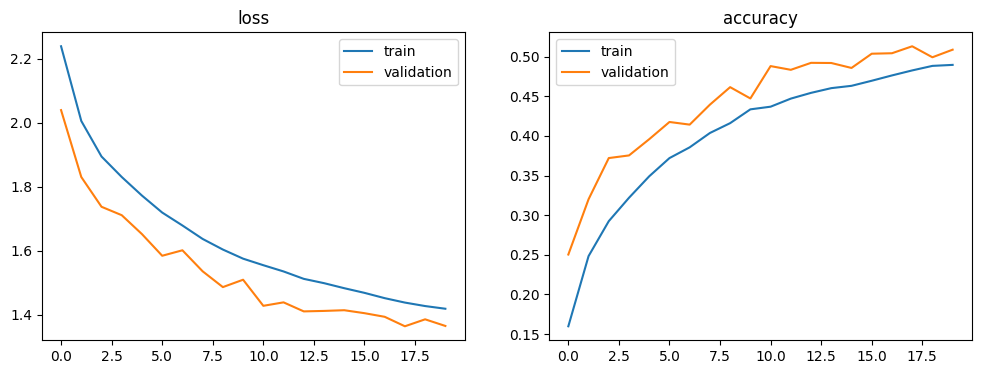

In [23]:
def plot_results(train_loss, valid_loss, train_acc, valid_acc ):
    fig,axs = plt.subplots(1,2,figsize = (12,4))
    axs[0].plot(train_loss.cpu().numpy(), label = 'train')
    axs[0].plot(valid_loss.cpu().numpy(), label = 'validation')
    axs[0].set_title('loss')
    axs[0].legend()
    axs[1].plot(train_acc.cpu().numpy(), label = 'train')
    axs[1].plot(valid_acc.cpu().numpy(), label = 'validation')
    axs[1].set_title('accuracy')
    axs[1].legend()
    plt.show()

plot_results(torch.tensor(history['train_loss']), torch.tensor(history['valid_loss']), torch.tensor(history['train_acc']), torch.tensor(history['valid_acc']))


Testing of the best epoch

In [29]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, testloader, criterion, metric, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

best epoch 0: Test Loss: 1.395 | Test Acc: 50.45%


In [30]:
model.eval()

n_classes = 10
n_samples = len(testset)

class_correct = torch.zeros(n_classes)
class_total   = torch.zeros(n_classes)

labels   = []
predicts = []

with torch.no_grad():

    for x,y in tqdm(testloader):
        x = x.to(device)
        y = y.to('cpu')

        y_pred = model.forward(x).to('cpu')

        cls_pred = torch.argmax(y_pred, dim=1)

        c = (cls_pred == y).squeeze() # one-hot vector

        for i in range(x.shape[0]):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1

        labels.append(y)
        predicts.append(cls_pred)

labels   = torch.cat(labels, dim = 0) # make it 1d array
predicts = torch.cat(predicts, dim = 0) # make it 1d array

for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        names_classes[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of airplane : 62 %
Accuracy of automobile : 68 %
Accuracy of  bird : 19 %
Accuracy of   cat : 23 %
Accuracy of  deer : 33 %
Accuracy of   dog : 36 %
Accuracy of  frog : 76 %
Accuracy of horse : 66 %
Accuracy of  ship : 55 %
Accuracy of truck : 62 %


Exercise
1. Try to implement and add to our network inception layer.
2. Try to increase the accuracy of the network,
3. Try your model for MNIST and compare with LeNet from WS3 (from torchvision.datasetes)   



In [122]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MNIST  resize for LeNet compatibility
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Creating a generator consistent with the training device
generator = torch.Generator(device=device)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    generator=generator
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1000,
    shuffle=False,
    generator=generator
)


#  Inception module
class InceptionModule(nn.Module):
    def __init__(self, in_channels):
        super(InceptionModule, self).__init__()
        self.branch1 = nn.Conv2d(in_channels, 8, kernel_size=1)

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, 8, kernel_size=1),
            nn.Conv2d(8, 8, kernel_size=3, padding=1)
        )

        self.branch5 = nn.Sequential(
            nn.Conv2d(in_channels, 8, kernel_size=1),
            nn.Conv2d(8, 8, kernel_size=5, padding=2)
        )

        self.pool_proj = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_channels, 8, kernel_size=1)
        )

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch3(x)
        out3 = self.branch5(x)
        out4 = self.pool_proj(x)
        return torch.cat([out1, out2, out3, out4], 1)  # 8*4 = 32 channels total

# LeNet + Inception Model
class InceptionNet(nn.Module):
    def __init__(self):
        super(InceptionNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)    # (1, 32, 32) -> (6, 28, 28)
        self.pool = nn.MaxPool2d(2, 2)                 # -> (6, 14, 14)
        self.incept = InceptionModule(6)              # -> (32, 14, 14)
        self.fc1 = nn.Linear(32 * 14 * 14, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.incept(x)
        x = x.view(-1, 32 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Instantiate model
model = InceptionNet().to(device)


# **trying to improve accuracy**

In [123]:
import torch.optim as optim
from tqdm import tqdm

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Stats
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {train_acc:.2f}%")


Epoch 1/5: 100%|██████████| 938/938 [00:13<00:00, 68.82it/s]


Epoch [1/5], Loss: 215.9174, Accuracy: 92.78%


Epoch 2/5: 100%|██████████| 938/938 [00:13<00:00, 68.30it/s]


Epoch [2/5], Loss: 57.2985, Accuracy: 98.11%


Epoch 3/5: 100%|██████████| 938/938 [00:13<00:00, 70.85it/s]


Epoch [3/5], Loss: 40.9112, Accuracy: 98.63%


Epoch 4/5: 100%|██████████| 938/938 [00:13<00:00, 70.02it/s]


Epoch [4/5], Loss: 32.5520, Accuracy: 98.92%


Epoch 5/5: 100%|██████████| 938/938 [00:13<00:00, 71.10it/s]

Epoch [5/5], Loss: 26.8801, Accuracy: 99.09%


# **Comparing to  MNIST and  LeNet from WS3**

In [124]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)       # (1, 32, 32) -> (6, 28, 28)
        self.pool = nn.MaxPool2d(2, 2)        # -> (6, 14, 14)
        self.conv2 = nn.Conv2d(6, 16, 5)      # -> (16, 10, 10)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))     # -> (6, 14, 14)
        x = self.pool(F.relu(self.conv2(x)))     # -> (16, 5, 5)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [125]:
def train_model(model, train_loader, test_loader, num_epochs=5):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%")

    return model


In [126]:
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy


In [127]:
print("Training InceptionNet...")
inception_model = InceptionNet()
train_model(inception_model, train_loader, test_loader)
inception_acc = evaluate_model(inception_model, test_loader)

print("\nTraining LeNet...")
lenet_model = LeNet()
train_model(lenet_model, train_loader, test_loader)
lenet_acc = evaluate_model(lenet_model, test_loader)

print("\nComparison:")
print(f"InceptionNet Test Accuracy: {inception_acc:.2f}%")
print(f"LeNet Test Accuracy: {lenet_acc:.2f}%")


Training InceptionNet...
Epoch [1/5], Loss: 239.0340, Accuracy: 91.72%
Epoch [2/5], Loss: 66.6372, Accuracy: 97.78%
Epoch [3/5], Loss: 47.0579, Accuracy: 98.46%
Epoch [4/5], Loss: 35.6891, Accuracy: 98.75%
Epoch [5/5], Loss: 31.0570, Accuracy: 98.92%
Test Accuracy: 98.94%

Training LeNet...
Epoch [1/5], Loss: 299.7469, Accuracy: 90.27%
Epoch [2/5], Loss: 85.2515, Accuracy: 97.20%
Epoch [3/5], Loss: 59.8625, Accuracy: 98.01%
Epoch [4/5], Loss: 45.8342, Accuracy: 98.46%
Epoch [5/5], Loss: 38.6641, Accuracy: 98.67%
Test Accuracy: 98.25%

Comparison:
InceptionNet Test Accuracy: 98.94%
LeNet Test Accuracy: 98.25%


Both models perform very well on the MNIST dataset, but:

InceptionNet achieved slightly better accuracy: 98.94%

LeNet achieved 98.25%

This shows that adding the Inception module improves performance by allowing the model to capture multi-scale features more effectively